In [22]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

logarithmic width = 4.57 and scale = 0.25


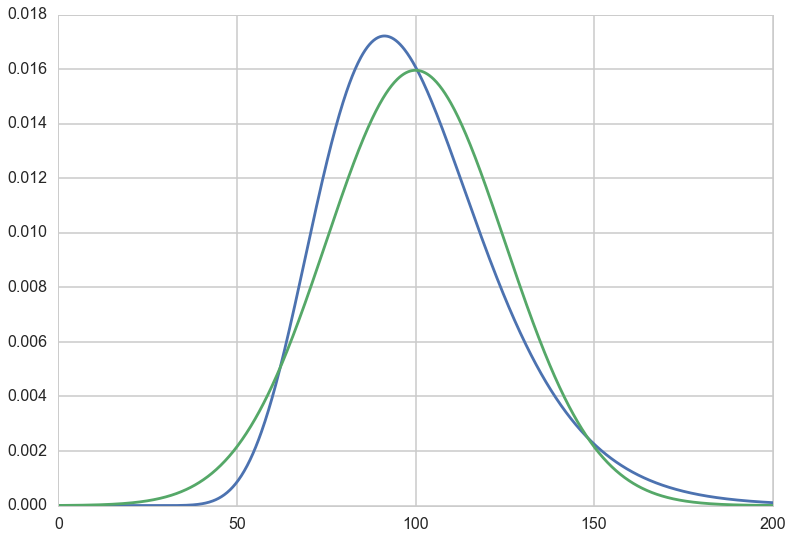

In [3]:
"""lets try and build a probability dist. for CPC"""
mean = 100
std = 25
var = std**2
mu = np.log(mean/(1+(var/mean**2))**(0.5))
sig = (np.log((1+(var/mean**2))))**(0.5)
print("logarithmic width = %.2f and scale = %.2f"%(mu,sig))

Plog = lambda x: (1/(x*sig*(2*np.pi)**(0.5)))*np.exp(-(np.log(x)-mu)**2/(2*sig**2))
P = lambda x: (1/(std*(2*np.pi)**(0.5)))*np.exp(-(x-mean)**2/(2*std**2))

xpts = np.linspace(0, 200, 1000)
plt.plot(xpts, Plog(xpts))
plt.plot(xpts, P(xpts))

In [4]:
all_prob_data = pd.read_csv('canadian_2015_election_seat_probabilities.csv', header=1)
all_prob_data

,Party,Minimum,Low,Expected,High,Maximum
0,CPC,77,100,118,139,186
1,NDP,27,51,66,90,115
2,LIB,74,124,146,161,185


In [6]:
# get the differences between the predicted expectation and the high and low limits
dif_low = [all_prob_data.loc[i,"Expected"] - all_prob_data.loc[i,"Low"] for i in all_prob_data.index]
dif_high = [all_prob_data.loc[i,"High"] - all_prob_data.loc[i,"Expected"] for i in all_prob_data.index]
print(dif_low, dif_high)

# define the maximum available seats and the number of seats required to have a majority government
max_seats = 338
maj_seats = 170

# allocate a set number of seats for the Bloc Quebecois and Green parties
other_seats = 8

[18, 15, 22] [21, 24, 15]


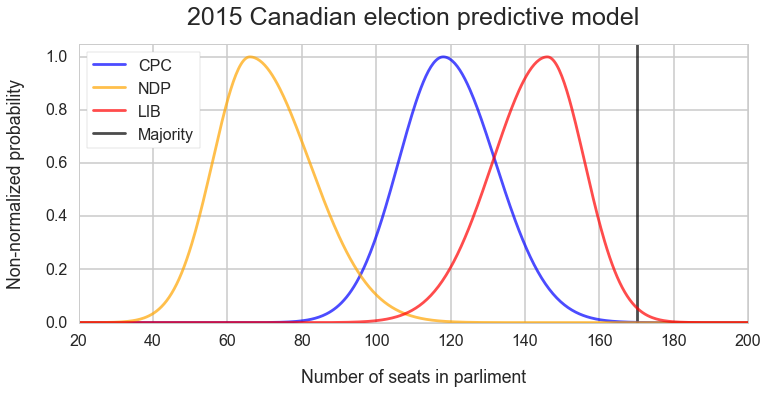

In [7]:
# set the width factor that relates the standard deviation to our differences
wfac = 1.5

# get the center points for each Gaussian
centers = [all_prob_data.loc[i,"Expected"] for i in all_prob_data.index]

# build the asymmetric Gaussians
norm_low = lambda i: sp.stats.norm(loc=centers[i],scale=dif_low[i]/wfac)
norm_high = lambda i: sp.stats.norm(loc=centers[i],scale=dif_high[i]/wfac)

# re-size each to match at a height of 1 and then merge into one function
resize_pdf_low = lambda i, x: norm_low(i).pdf(x)*1.0/norm_low(i).pdf(centers[i])
resize_pdf_high = lambda i, x: norm_high(i).pdf(x)*1.0/norm_high(i).pdf(centers[i])
merge_pdfs = lambda i, x: resize_pdf_low(i,x) if x <= centers[i] else resize_pdf_high(i,x)

plt.figure(figsize=(12,5))
party_colors = ['blue', 'orange', 'red']
xpts = np.linspace(0, max_seats, 1000)
for i in all_prob_data.index:
    plt.plot(xpts, [merge_pdfs(i,x) for x in xpts], color=party_colors[i], alpha=0.7, label=all_prob_data.loc[i,"Party"])
plt.xlim(20, 200)
plt.ylim(0, 1.05)
plt.vlines(maj_seats, 0, 2, color='black', alpha=0.7, label='Majority')
box = dict(boxstyle='square', facecolor='lightgrey', alpha=0.7)
plt.legend(loc='upper left', frameon=True)
plt.xlabel("Number of seats in parliment", labelpad=20)
plt.ylabel("Non-normalized probability", labelpad=20)
plt.title("2015 Canadian election predictive model", y=1.05, fontsize=25)

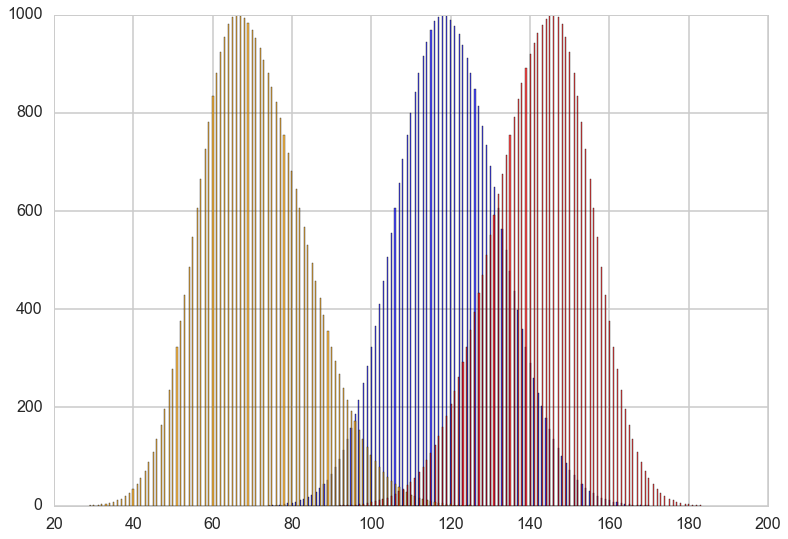

In [8]:
# make a set of 1D arrays that can be sampled using np.random.choice

discrete_pdfs = [[merge_pdfs(i,x) for x in range(max_seats)] for i in all_prob_data.index]
hist_pdfs_dict = {}
for i in all_prob_data.index:
    hist_pdfs = []
    for j in range(len(discrete_pdfs[0])):
        for k in range(int(discrete_pdfs[i][j]*1000)):
            hist_pdfs.append(j)
    hist_pdfs_dict[all_prob_data.loc[i,"Party"]] = hist_pdfs
    plt.hist(hist_pdfs, bins=max_seats, color=party_colors[i], alpha=0.7)

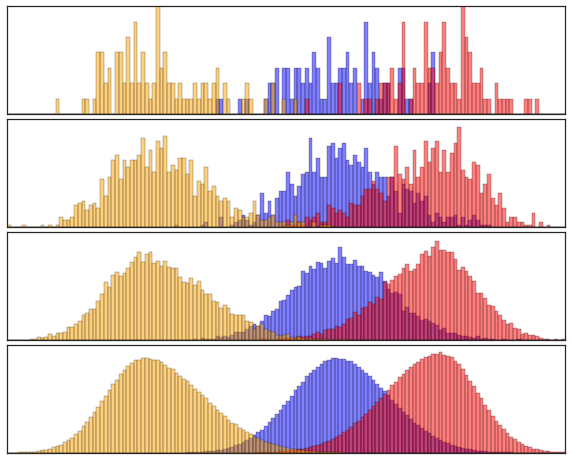

In [45]:
# do some random sampling of our distributions

sns.set_style("white")
sizes = [100, 1000, 10000, 1000000]
plt.figure(figsize=(10,8))
for i in range(4):
    marker = int('41'+str(i+1))
    ax = plt.subplot(marker)
    j = 0
    for key in hist_pdfs_dict:
        plt.hist(np.random.choice(hist_pdfs_dict[key], size=sizes[i]), bins=range(0,max_seats,1),
                 color=party_colors[-j], alpha=0.5)
        plt.xlim(30,180)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        j += 1
plt.subplots_adjust(hspace=0.05)
plt.savefig('random_sample.png', bbox_inches='tight', dpi=300)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,
         0.,  0.,  2.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

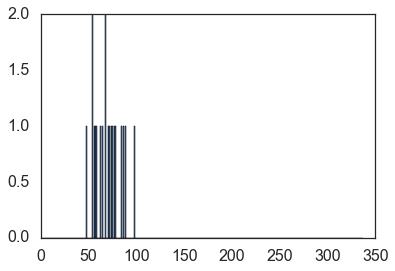

In [32]:
plt.hist(np.random.choice(hist_pdfs_dict["NDP"], size=20), bins=range(0,max_seats,1))

In [ ]:
sns.set_style("whitegrid")

In [268]:
# create routine that determines Conservative and Liberal seats randomly, then decides New Democratic seats by elimination

def RandomVotes():
    
    # initialize to 0 so that the following while loop will run
    CPC_seats, LIB_seats = 0, 0
    
    # throw away guesses that are less than the predicted limits of our model
    while CPC_seats < all_prob_data.loc[0,"Minimum"] or CPC_seats > all_prob_data.loc[0,"Maximum"]:
        CPC_seats = np.random.choice(hist_pdfs_dict["CPC"])
    while LIB_seats < all_prob_data.loc[2,"Minimum"] or LIB_seats > all_prob_data.loc[2,"Maximum"]:
        LIB_seats = np.random.choice(hist_pdfs_dict["LIB"])
    
    NDP_seats = max_seats - other_seats - CPC_seats - LIB_seats # other_seats was set as 8 based on the CBC expected values
    return CPC_seats, NDP_seats, LIB_seats

In [283]:
def SimulateElection(numer_of_outcomes):
    winners, majorities = [], []
    CPC_seats, NDP_seats, LIB_seats = [], [], []
    for i in range(numer_of_outcomes):
        CPC, NDP, LIB = RandomVotes()
        winner_name = dict([(CPC,"CPC"), (NDP,"NDP"), (LIB,"LIB")])
        CPC_seats.append(CPC)
        NDP_seats.append(NDP)
        LIB_seats.append(LIB)
        winner = max([CPC, NDP, LIB])
        winners.append(winner_name[winner])
        if winner >= maj_seats:
            majorities.append(winner_name[winner])
    return CPC_seats, NDP_seats, LIB_seats, winners, majorities

CPC, NDP, LIB, winners, majorities = SimulateElection(1000)
print(winners)
print(majorities)

['LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'CPC', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'LIB', 'LIB', 'LIB', 'CPC', 'LIB', 'NDP', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB', 'LIB'